In [129]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [205]:
import glob
import re
import pandas as pd
import json
import subprocess
import tqdm
import seaborn as sns
import math

In [206]:
benchmarks = glob.glob("../benchmarks-new/*.fz")

In [207]:
def timing_out(timing_file):
    try:
        with open(timing_file) as f:
            # print(f)
            data = json.load(f)
            return data["results"][0]["median"]
    except:
        None

In [208]:
names = [x.split(".")[2].split("/")[-1] for x in benchmarks if "factor" not in x]
names

['sum',
 'kepler0',
 'shoelace-formula',
 'add-assoc',
 'himmilbeau',
 'sineOrder3',
 'matrixDeterminant2',
 'rigidBody1',
 'delta4',
 'sqroot',
 'rigidBody2',
 'matrixDeterminant',
 'test01_sum3',
 'kepler1']

In [209]:
def parse_bound(bnd: str):
    bnd = bnd.strip("[]")
    # print("bnd", bnd)
    bnd = bnd.strip()

    if "b" in bnd:
        mantissa = int(bnd.split("b")[0])
        exp = int(bnd.split("b")[1])
        # print("mantissa, exp)
        return mantissa * (2 ** exp)
    else:
        return float(bnd)
    # print(left, right)

In [210]:
def parse_gappa_out(filename):
    try:
        with open(filename, "r") as f:
            file = f.read()
        if "Error" in file:
            return None
            
        file = re.sub("\{.*?\}", "", file).strip()
        # try:
        bounds = [parse_bound(x.strip()) for x in file.split("in")[1].strip().split(",")]
        # except as e:
        #     print(file, e)
            # try:
            # except:
            #     print(filename, ":", file)
            
        lb = float(bounds[0])
        ub = float(bounds[1])
        return (lb, ub)
        
    except:
        (0,0)

<>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_126839/3921668004.py:8: SyntaxWarning: invalid escape sequence '\{'
  file = re.sub("\{.*?\}", "", file).strip()


In [357]:
def parse_fptaylor_out(filename):
    try:
        with open(filename, "r") as f:
            file = f.read()
            abs_error = None
            rel_error= None
            for line in file.split("\n"):
                if "Absolute error" in line:
                    try:
                        abs_error = float(line.split(":")[1].split()[0])
                    except:
                        print("abs error", line)
                if "Relative error" in line:
                    rel_error = float(line.split(":")[1].split()[0])
                # print(line)
            # print(file)
        return(abs_error, rel_error)
    except:
        None

In [358]:
# file

In [359]:
def sample_post(fname):
    sample = subprocess.run(f"python ../benchmarks-new/{fname}.py", shell=True, check=True, capture_output=True)
    post = float(sample.stdout.strip())
    sampled_bnd = subprocess.run(f"../fuzzrs/target/release/fuzzrs --input ../benchmarks-new/{fname}.fz --post={post}", shell=True, check=True, capture_output=True)
    post_bnd = float(sampled_bnd.stdout.decode().split("\n")[2].split(":")[1].strip())
    post_bnd_abs = max(abs(post) * (math.exp(post_bnd) - 1), abs(post) * (1 - math.exp(-post_bnd)))
    return (post, post_bnd, post_bnd_abs)

In [360]:
results = []
timings = []
post_samples = {}
for fname in tqdm.tqdm(names):
    print(fname)
    with open(f"../benchmarks-new/{fname}.fz.out") as f:
        lines = str(f.read()).split("\n")
        # print(lines)
        pre_rel = lines[0].split(":")[1].strip().replace("Some", "").replace("(", "").replace(")", "")
        pre_abs = lines[1].split(":")[1].strip()

    with open(f"../benchmarks-new/{fname}-factor.fz.out") as f:
        lines = str(f.read()).split("\n")
        # print(lines)
        pre_rel_factor = lines[0].split(":")[1].strip().replace("Some", "").replace("(", "").replace(")", "")
        pre_abs_factor = lines[1].split(":")[1].strip()
        
    g_abs = parse_gappa_out(f"../benchmarks-new/{fname}-abs.g.out")
    if g_abs:
        g_abs = g_abs[1]
    else:
        g_abs = None
    g_rel = parse_gappa_out(f"../benchmarks-new/{fname}-rel.g.out")
    if g_rel:
        g_rel = g_rel[1]
    else:
        g_rel = None

    fptaylor_abs, fptaylor_rel = parse_fptaylor_out("../benchmarks-new/kepler0.fptaylor.out")
    result = {
        "benchmark": fname,
        "pre-rel": pre_rel,
        "pre-abs": pre_abs,
        "pre-rel-factor": pre_rel_factor,
        "pre-abs-factor": pre_abs_factor,
        "gappa-abs": g_abs,
        "gappa-rel": g_rel,
        "fptaylor-abs": fptaylor_abs,
        "fptaylor-rel": fptaylor_rel,
    }
    timing = {
        "benchmark": fname,
        "gappa-abs": timing_out(f"../benchmarks-new/{fname}-abs.g.json"),
        "gappa-rel": timing_out(f"../benchmarks-new/{fname}-rel.g.json"),
        "numfuzz": timing_out(f"../benchmarks-new/{fname}.fz.json"),
        "numfuzz-factor": timing_out(f"../benchmarks-new/{fname}-factor.fz.json"),
        "fptaylor-rel": timing_out(f"../benchmarks-new/{fname}-rel.fptaylor.json"),
        "fptaylor-abs": timing_out(f"../benchmarks-new/{fname}-abs.fptaylor.json"),
    }
    results.append(result)
    timings.append(timing)

    samples = [sample_post(fname) for _ in range(1000)]
    post_samples[fname] = samples
    # print(result)

  0%|                                                                                                                                                  | 0/14 [00:00<?, ?it/s]

sum


  7%|█████████▊                                                                                                                                | 1/14 [00:28<06:05, 28.13s/it]

kepler0


 14%|███████████████████▋                                                                                                                      | 2/14 [00:58<05:53, 29.48s/it]

shoelace-formula


 21%|█████████████████████████████▌                                                                                                            | 3/14 [01:27<05:22, 29.29s/it]

add-assoc


 29%|███████████████████████████████████████▍                                                                                                  | 4/14 [01:51<04:32, 27.28s/it]

himmilbeau


 36%|█████████████████████████████████████████████████▎                                                                                        | 5/14 [02:17<04:00, 26.74s/it]

sineOrder3


 43%|███████████████████████████████████████████████████████████▏                                                                              | 6/14 [02:44<03:34, 26.77s/it]

matrixDeterminant2


 50%|█████████████████████████████████████████████████████████████████████                                                                     | 7/14 [03:16<03:18, 28.39s/it]

rigidBody1


 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 8/14 [03:41<02:43, 27.31s/it]

delta4


 64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 9/14 [04:10<02:19, 28.00s/it]

sqroot


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 10/14 [04:39<01:52, 28.23s/it]

rigidBody2


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 11/14 [05:08<01:25, 28.35s/it]

matrixDeterminant


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 12/14 [05:42<01:00, 30.07s/it]

test01_sum3


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 13/14 [06:07<00:28, 28.63s/it]

kepler1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [06:43<00:00, 28.83s/it]


In [361]:
results_df = pd.DataFrame(results)
results_transpose = results_df.transpose()
results_transpose.columns = results_transpose.iloc[0]

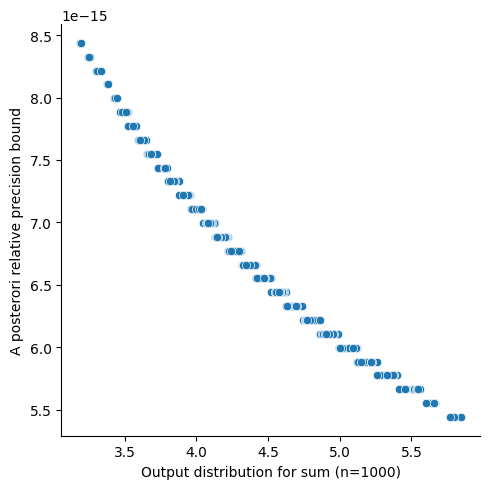

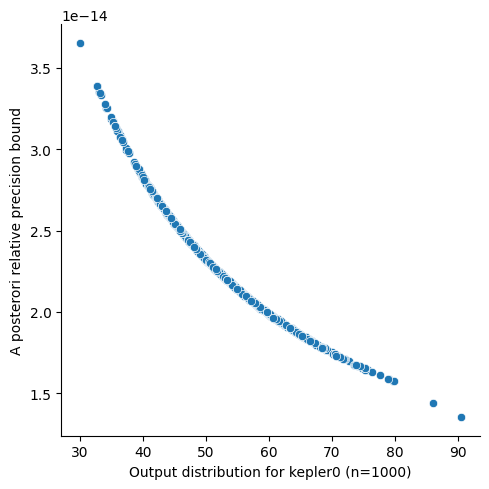

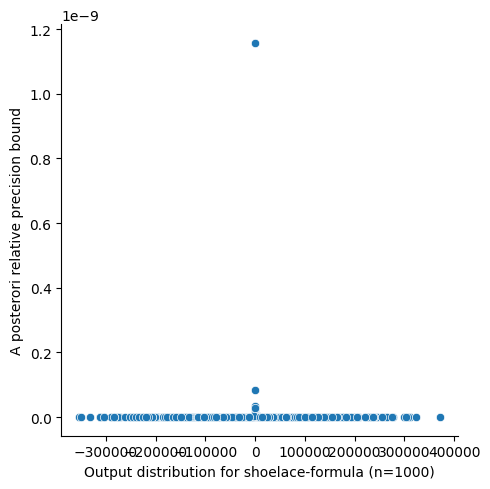

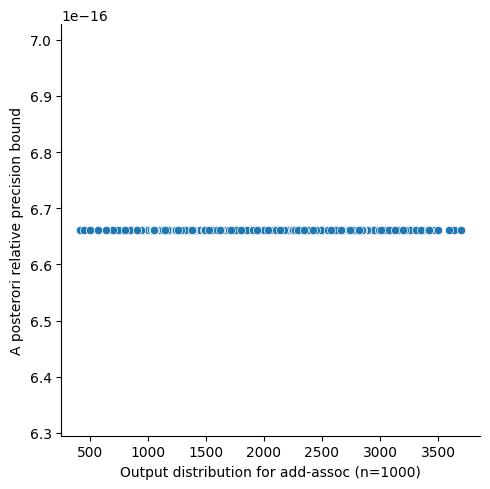

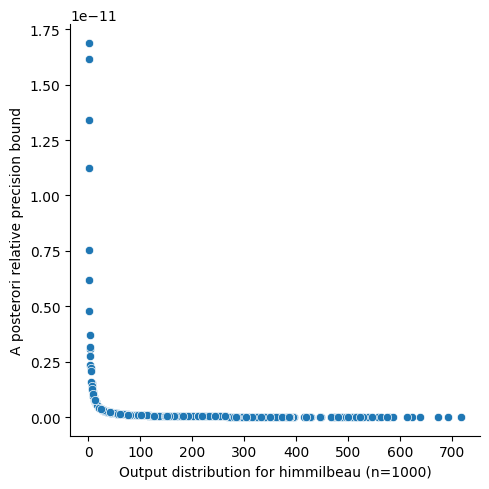

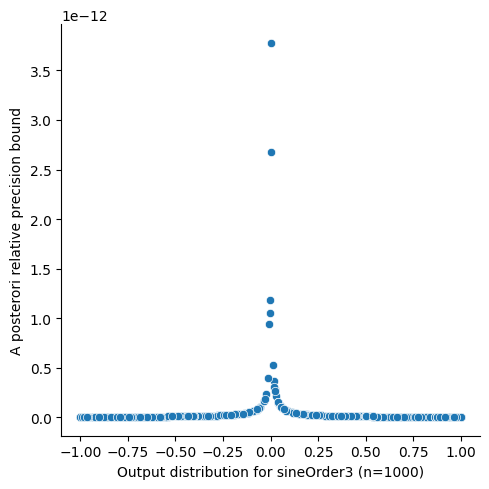

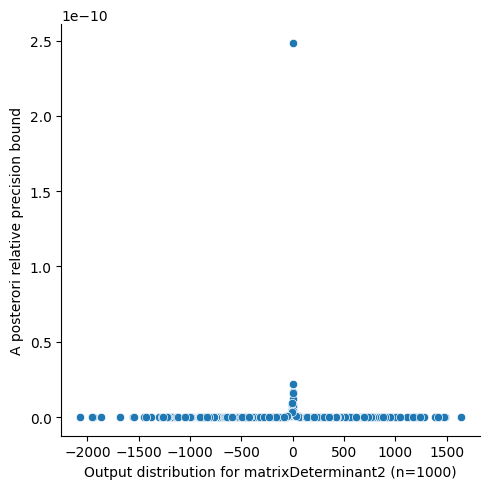

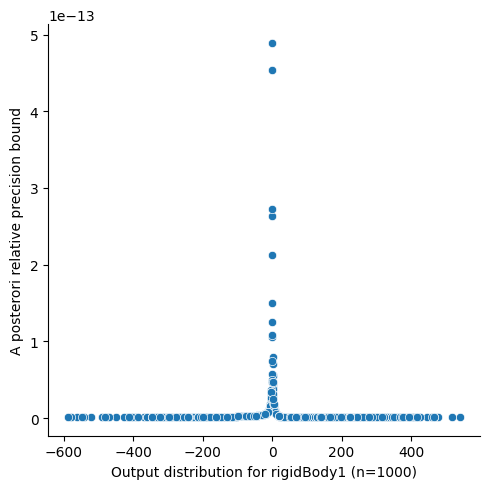

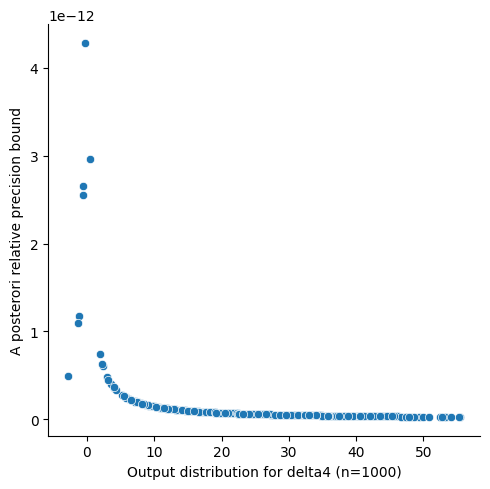

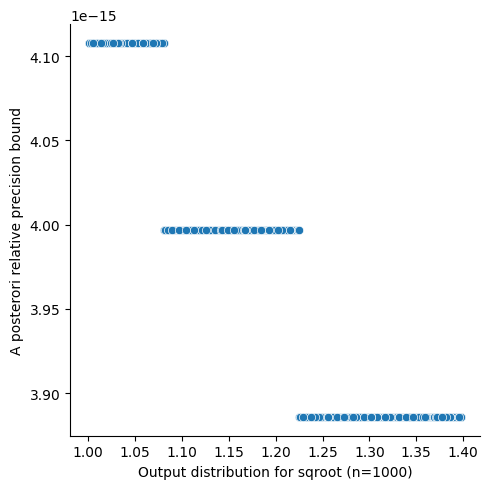

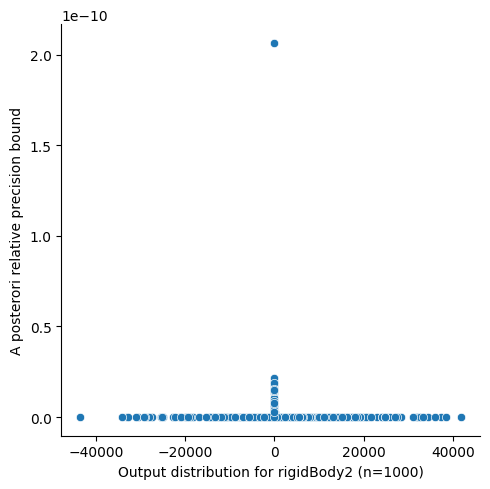

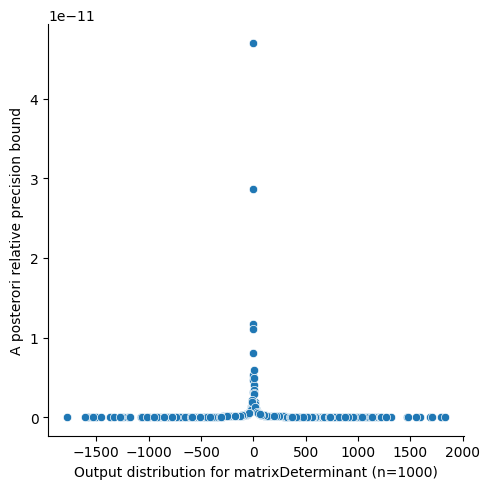

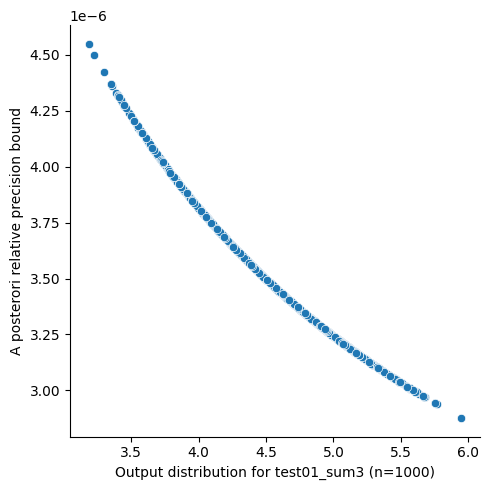

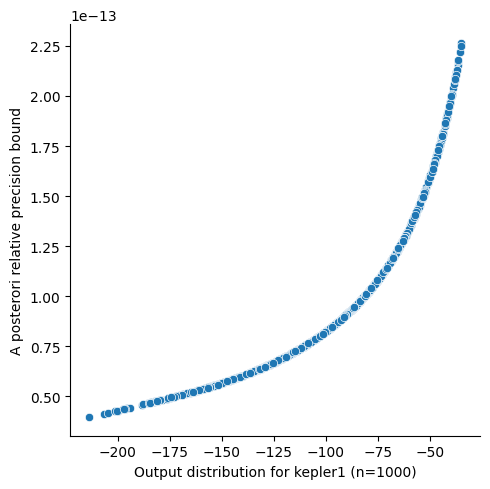

In [362]:
for fname in names:
    # samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
    # gappa_abs = results_transpose[fname]["gappa-abs"]
    # gappa_rel = results_transpose[fname]["gappa-rel"]
    # # convert to rel
    # g = sns.jointplot(samples_df, x = "result", y = "error-bound-rel", kind="scatter", marginal_kws={"fill": True, "bins": 30})
    # g.savefig(f"{fname}.svg")
    samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
    gappa_abs = results_transpose[fname]["gappa-abs"]
    gappa_rel = results_transpose[fname]["gappa-rel"]
    # convert to rel
    g = sns.relplot(samples_df, x = "result", y = "error-bound-rel")
    g.set_axis_labels(f"Output distribution for {fname} (n={len(samples_df)})", "A posterori relative precision bound")
    g.savefig(f"{fname}.svg")

In [363]:
timings_df = pd.DataFrame(timings)

In [366]:
results_df.to_csv("results-2025-11-12.csv")
results_df

,benchmark,pre-rel,pre-abs,pre-rel-factor,pre-abs-factor,gappa-abs,gappa-rel,fptaylor-abs,fptaylor-rel
0,sum,None,2.6645352591003757e-14,None,1.3322676295501878e-14,6.661338e-15,NaN,None,None
1,kepler0,None,9.53407663928374e-13,None,6.810054742345528e-13,1.982414e-13,NaN,None,None
2,shoelace-formula,None,3.996806885453452e-9,None,1.998403442726726e-9,NaN,NaN,None,None
3,add-assoc,6.661338147750937e-16,2.6645352591003757e-12,4.440892098500625e-16,1.7763568394002505e-12,1.364242e-12,0.000000e+00,None,None
4,himmilbeau,None,1.1224354778960333e-11,None,5.986322548778844e-12,2.000178e-12,NaN,None,None
5,sineOrder3,None,5.937035405398565e-15,None,4.2407393152643635e-15,2.068635e-15,NaN,None,None
6,matrixDeterminant2,None,2.2648549702353193e-11,None,6.661338147750939e-12,7.005951e-12,NaN,None,None
7,rigidBody1,None,9.79216707719388e-13,None,8.160139230994901e-13,5.897505e-13,NaN,None,None
8,delta4,None,1.1438511683081742e-12,None,5.004348861348262e-13,1.767546e-13,NaN,None,None
9,sqroot,3.774758283725525e-15,4.85722573273506e-15,1.332267629550187e-15,1.734723475976807e-15,1.040834e-15,1.203606e-16,None,None


In [365]:
timings_df.to_csv("timings-2025-11-12.csv")

## Break

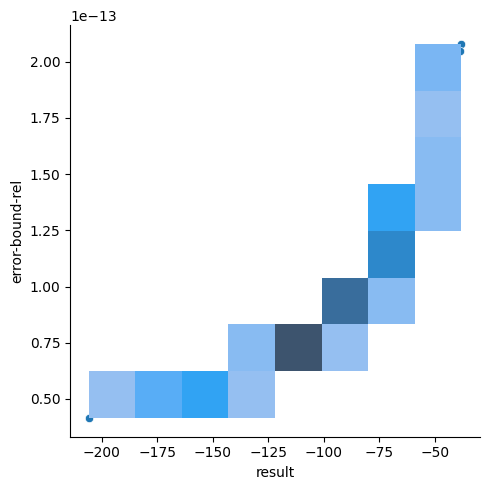

In [283]:
samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.relplot(samples_df, x = "result", y = "error-bound-rel")
g.set_axis_labels(f"Output distribution for {fname}", "A posterori relative error bound")
# g.map_dataframe(
#     sns.histplot, x="result", y = "error-bound-rel" # fill=True, levels=100, common_norm=True
# )
g.savefig(f"{fname}.svg")

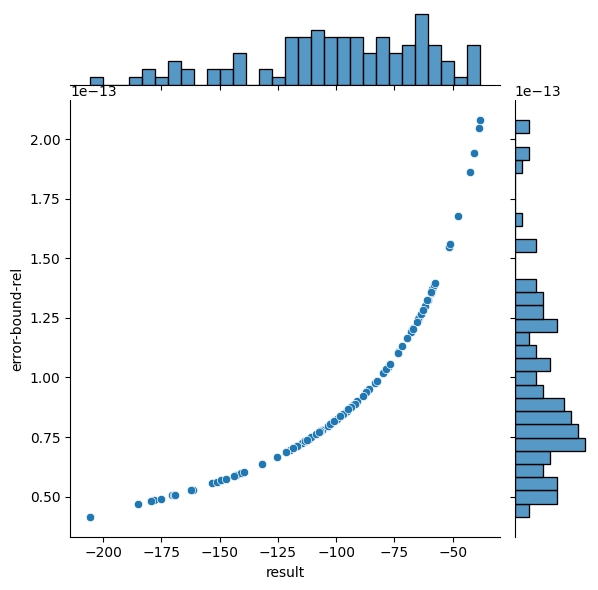

In [288]:
samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.jointplot(samples_df, x = "result", y = "error-bound-rel", kind="scatter", marginal_kws={"fill": True, "bins": 30})
g.savefig(f"{fname}.svg")

In [248]:
gappa_rel

nan

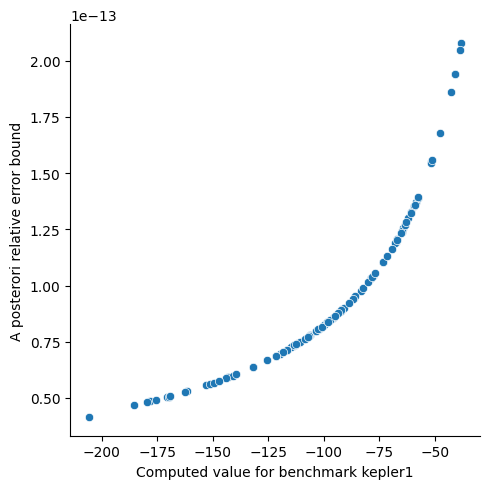

In [263]:
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.relplot(samples_df, x = "result", y = "error-bound-rel")
g.set_axis_labels(f"Computed value for benchmark {fname}", "A posterori relative error bound")
# ax = g.ax
# ax.axhline(y=gappa_abs, linestyle="--", color="red", linewidth=1)
# g.set(yscale="log")

In [232]:
fname

'kepler1'

In [233]:
results_transpose[fname]["gappa-abs"]

5.381494361245132e-13

In [234]:
results_transpose[fname]["gappa-abs"]

5.381494361245132e-13

In [179]:
parse_gappa_out(f"../benchmarks-new/{fname}-abs.g.out")[1]

5.381494361245132e-13

(-134.93458819965818, 6.239453398393574e-14)

In [37]:
pd.DataFrame(results)

,benchmark,pre-rel,pre-abs,pre-rel-factor,pre-abs-factor,gappa-abs,gappa-rel
0,sum,None,2.6645352591003757e-14,None,1.3322676295501878e-14,3.663736e-15,NaN
1,kepler0,None,9.53407663928374e-13,None,6.810054742345528e-13,1.231726e-13,NaN
2,shoelace-formula,None,3.996806885453452e-9,None,1.998403442726726e-9,NaN,NaN
3,add-assoc,6.661338147750937e-16,2.6645352591003757e-12,4.440892098500625e-16,1.7763568394002505e-12,6.821210e-13,3.330669e-16
4,himmilbeau,None,1.1224354778960333e-11,None,5.986322548778844e-12,1.000089e-12,NaN
5,sineOrder3,None,5.937035405398565e-15,None,4.2407393152643635e-15,8.886006e-16,NaN
6,matrixDeterminant2,None,2.2648549702353193e-11,None,6.661338147750939e-12,3.502976e-12,NaN
7,rigidBody1,None,9.79216707719388e-13,None,8.160139230994901e-13,2.948752e-13,NaN
8,delta4,None,1.1438511683081742e-12,None,5.004348861348262e-13,1.393602e-13,NaN
9,sqroot,3.774758283725525e-15,4.85722573273506e-15,1.332267629550187e-15,1.734723475976807e-15,5.707240e-16,6.609459e-16


In [38]:
pd.DataFrame(timings)

,gappa-abs,gappa-rel,numfuzz,numfuzz-factor,fptaylor
0,0.105900,NaN,0.007102,None,0.829767
1,0.123544,NaN,0.009509,None,3.413505
2,NaN,NaN,0.021862,None,0.024149
3,0.019700,0.042746,0.006446,None,NaN
4,0.233510,NaN,0.005215,None,0.043843
5,0.028029,NaN,0.003906,None,0.031735
6,0.312490,NaN,0.016237,None,24.484982
7,0.033758,NaN,0.004899,None,0.292203
8,0.179034,NaN,0.010954,None,0.580256
9,0.305686,0.040217,0.005942,None,0.018666
